<a href="https://colab.research.google.com/github/ElenaPeralPastor/AA_PRACTICA2_GRUPO_2/blob/main/PROYECTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RECONOCIMIENTO FACIAL DE EMOCIONES**
* Asignatura: **PROYECTO INTEGRADOR III**
* Impartida por: **Cynthya García de Jesús**



###**1. Importación de las librerías necesarias**

Se importan las librerías necesarias para el proceso del proyecto.

In [128]:
import numpy as np 
import pandas as pd 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils import np_utils


###**2. Base de datos seleccionada**

Se ha seleccionado la base de datos fer2013.csv, es una base de datos de Kaggle que contiene imágenes etiquetadas de emociones humanas. Las imágenes representan expresiones faciales de seis emociones diferentes: alegría, tristeza, ira, sorpresa, disgusto y miedo. Es una base de datos muy utilizada en el campo de la inteligencia artificial y el reconocimiento de emociones.

In [129]:
data = pd.read_csv('fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [153]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


###**3. Preprocesar las imágenes.**

Primero se eliminarán las filas que contienen valores nulos o faltantes en la columna "pixels".


In [130]:
data = data.dropna(subset=["pixels"])

A continuación se obtendrán los datos de la columna "pixels" y se dividirán en listas.

In [131]:
pixels = data["pixels"].tolist()

Ahora se convertirán las listas de píxeles en matrices numpy, se obtendrán las etiquetas (0-6) de la columna "emotion" y se dividirán los datos en train y test.

In [132]:
# convertir las listas de píxeles en matrices numpy
images = []
for pixel_sequence in pixels:
    pixel_array = np.asarray([int(pixel) for pixel in pixel_sequence.split()])
    if pixel_array.size == 2304:  # verificar que el tamaño de la imagen sea de 2304 píxeles
        images.append(pixel_array.reshape(48, 48))

images = np.array(images)

# obtener las etiquetas (0-6) de la columna "emotion"
labels = pd.get_dummies(data['emotion']).values

# dividir los datos en dos conjuntos: uno para entrenamiento (train) y otro para pruebas (test)
train_images, train_labels = images[:28709], labels[:28709]
test_images, test_labels = images[28709:], labels[28709:]


Echamos un vistazo a los **datos de entrenamiento**:

In [133]:
print(train_images.shape)

(28709, 48, 48)


In [134]:
# Vemos la matriz de la imagen número 30.000 (28x28)
np.set_printoptions(precision=2, suppress=True, linewidth=145)
print(np.matrix(train_images[20000]))

[[ 56  84 137 ...  55  54  55]
 [ 79 103 155 ...  57  55  55]
 [101 105 153 ...  56  56  53]
 ...
 [123 139 134 ...  89  33 111]
 [135 138 139 ...  90  50 102]
 [142 140 149 ...  76  71  72]]


In [135]:
# La imagen anterior corresponde con happy. Hasta se puede intuir:
train_labels[20000]

array([0, 0, 0, 1, 0, 0, 0], dtype=uint8)

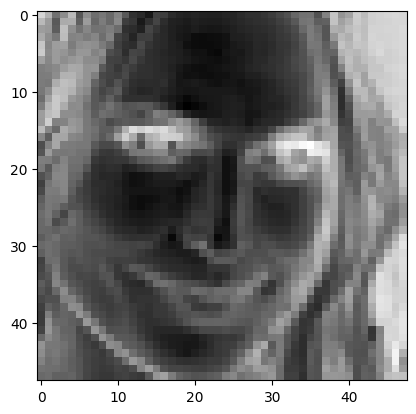

In [136]:
# Veamos el elemento 30000 y pintémoslo con matplotlib
import matplotlib.pyplot as plt
digit = train_images[20000]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [137]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Fear,5121
2,Sad,6077
3,Neutral,6198
4,Happy,8989
5,Surprise,4002
6,Digust,547


In [138]:
emotion_counts.emotion

0       Angry
1        Fear
2         Sad
3     Neutral
4       Happy
5    Surprise
6      Digust
Name: emotion, dtype: object

In [139]:
emotion_counts.number

0    4953
1    5121
2    6077
3    6198
4    8989
5    4002
6     547
Name: number, dtype: int64

In [140]:
data.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

###**4. Creación del modelo de red neuronal utilizando una red convolucional (CNN).**

Este modelo consiste en una red convolucional (CNN) con
* 3 capas convolucionales con capa de pooling y una capa de dropout. La salida de la última capa convolucional se aplana y se pasa a través de una capa densa con 64 neuronas y una función de activación ReLU. 
* La capa de salida consiste en una capa densa con 7 neuronas (una para cada categoría de expresión facial) y una función de activación softmax para obtener las probabilidades de cada categoría.
*  Contiene imágenes de 48x48 píxeles en escala de grises, por lo que la entrada del modelo debe tener una forma de (48, 48, 1).

* Se ha utilizado entropía cruzada categórica, ya que se trata de un problema de clasificación multiclase.

In [141]:
# Definir la arquitectura de la red
model = tf.keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Mostrar el resumen del modelo
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 10, 10, 64)       0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 10, 10, 64)       

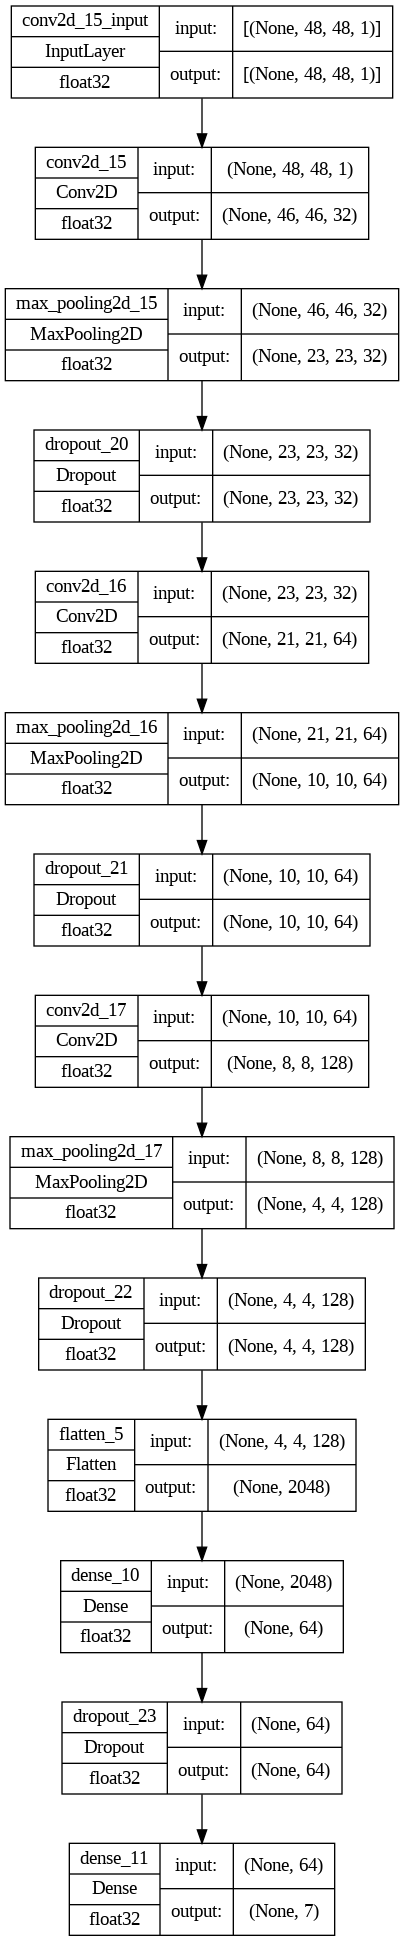

In [142]:
tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

###**5.- Preparamos los datos de imagen con alguna transformación. NORMALIZACION**

In [143]:
# 6.- PREPARACIÓN LAS ETIQUETAS
# from keras import utils
# from keras.utils import to_categorical
train_labels[20000]

array([0, 0, 0, 1, 0, 0, 0], dtype=uint8)

In [144]:
# data normalization
train_images = train_images / 255.
test_images = test_images / 255.


###**6. Entrenar el modelo**

* fit: ajusta el modelo a sus datos de entrenamiento.
* epochs: Épocas: un límite arbitrario, definido como "una pasada sobre todo el conjunto de datos", que se utiliza para separar el entrenamiento en distintas fases, que es útil para el registro y la evaluación periódica. Como no hay initial_epoch, en este caso va hasta la época 50 desde la 1.
* batch_size: Entero o NULO. Número de muestras por actualización de gradiente. Si no se especifica, batch_size se establecerá de forma predeterminada en 32.


Como se puede observar el accuracy dado es muy pequeño esto se debe al número de iteraciones (epochs), se ha probado con 100 epochs y se obtiene una accuracy alta pero se necesita mucho tiempo de compilación. Se puede apreciar como con cada iteración las pérdidas van disminuyendo y el accuracy va aumentando.

In [203]:
# Entrenar el modelo
history = model.fit(train_images, train_labels, epochs=50, batch_size=1000, validation_data=(test_images, test_labels))


Epoch 1/50
29/29 [==============================] - 129s 4s/step - loss: 1.4705 - accuracy: 0.4392 - val_loss: 1.3913 - val_accuracy: 0.4802
Epoch 2/50
29/29 [==============================] - 131s 5s/step - loss: 1.4459 - accuracy: 0.4492 - val_loss: 1.3620 - val_accuracy: 0.4858
Epoch 3/50
29/29 [==============================] - 130s 4s/step - loss: 1.4323 - accuracy: 0.4554 - val_loss: 1.3451 - val_accuracy: 0.4919
Epoch 4/50
29/29 [==============================] - 131s 5s/step - loss: 1.4062 - accuracy: 0.4620 - val_loss: 1.3271 - val_accuracy: 0.5015
Epoch 5/50
29/29 [==============================] - 130s 5s/step - loss: 1.3895 - accuracy: 0.4716 - val_loss: 1.3142 - val_accuracy: 0.5035
Epoch 6/50
29/29 [==============================] - 129s 4s/step - loss: 1.3727 - accuracy: 0.4772 - val_loss: 1.2931 - val_accuracy: 0.5075
Epoch 7/50
29/29 [==============================] - 130s 4s/step - loss: 1.3582 - accuracy: 0.4816 - val_loss: 1.2844 - val_accuracy: 0.5123
Epoch 8/50
29

Se puede ver en el siguiente gráfico como el accuracy va aumentando.

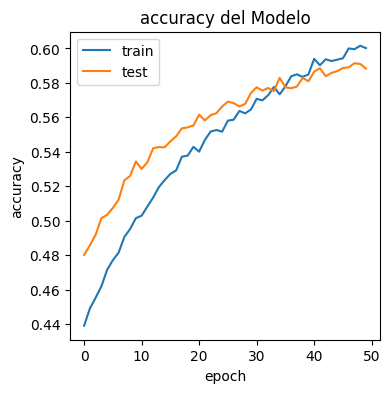

In [204]:
plt.figure(figsize = (4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy del Modelo')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Por otro lado también se puede observar como las pérdidas van disminuyendo.

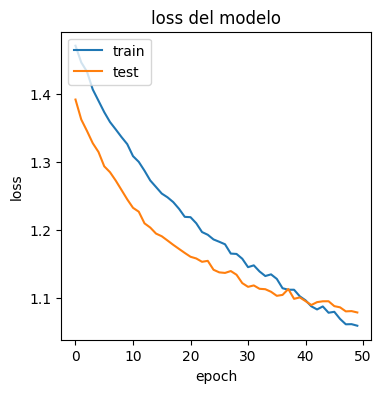

In [205]:
plt.figure(figsize = (4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss del modelo')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("model_loss")
plt.show()

###**7. Evaluar el modelo**

Ahora se evaluará nuestro modelo con la función evaluate.

In [208]:
# VERIFICAMOS NUESTRO MODELO YA ENTRENADO, CONTRA EL CONJUNTO DE PRUEBAS
test_loss, test_acc = model.evaluate(test_images, test_labels)



225/225 [==============================] - 7s 29ms/step - loss: 1.0782 - accuracy: 0.5883


In [209]:
print('test_loss:', test_loss)
print('test_acc:', test_acc)

test_loss: 1.0781543254852295
test_acc: 0.5883254408836365


Se creará la matriz de confusión, en la cual se puede apreciar como predice mejor algunas clases que otras, esto se debe al bajo accuracy.

In [210]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

225/225 [==============================] - 8s 34ms/step


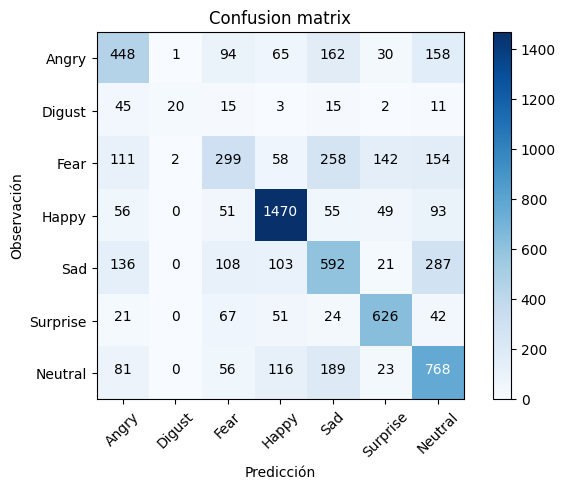

In [211]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
# Predicción de valores desde el dataset de validación
Y_pred = model.predict(test_images)
# Convertir en predicciones de clases desde los vectores one-hot encoding 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convertir en clases de observación desde los vectores one-hot encoding
Y_true = np.argmax(test_labels, axis = 1) 
# Computar la matriz de confusión
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
classes = ['Angry', 'Digust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Dibujar la matriz de confusión
plot_confusion_matrix(confusion_mtx, classes = classes)

###**8. GENERACIÓN DE PREDICCIONES**

A continuación se seleccionará una imagen al azar del DataFrame utilizado y se verá si el modelo es capaz de predecirla bien.

1/1 [==============================] - 0s 24ms/step


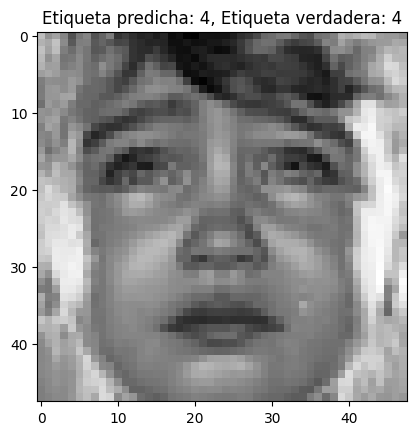

In [214]:
import cv2

# obtener una muestra aleatoria del conjunto de datos de test
ejemplo = data[data['Usage']=='PrivateTest'].sample(1)

# convertir la imagen de píxeles en una matriz numpy
pixels = ejemplo['pixels'].values[0].split(' ')
image = np.array([int(p) for p in pixels], dtype=np.uint8).reshape(48, 48)

# redimensionar la imagen a 48x48
image = cv2.resize(image, (48, 48))

# normalizar los valores de píxeles en el rango [0, 1]
image = image / 255.0

# agregar una dimensión adicional para la convolución
image = np.expand_dims(image, axis=-1)

# agregar una dimensión adicional para la muestra
image = np.expand_dims(image, axis=0)

# obtener la etiqueta predicha de la imagen
pred = model.predict(image)

# obtener la clase con la etiqueta predicha
pred_class = np.argmax(pred, axis=1)[0]

# obtener la etiqueta verdadera de la imagen
true_label = ejemplo['emotion'].values[0]

# mostrar la imagen
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Etiqueta predicha: {pred_class}, Etiqueta verdadera: {true_label}")
plt.show()


Por último, se han sacado algunas imágenes de internet para probar el modelo.

Las siete clases son:

* clase 0: Angry (Enojado)
* clase 1: Disgust (Disgustado)
* clase 2: Fear (Asustado)
* clase 3: Happy (Feliz)
* clase 4: Sad (Triste)
* clase 5: Surprise (Sorprendido)
* clase 6: Neutral (Neutral)

Como se puede observar predice bien todos los casos, pese a su bajo accuracy, por lo que se puede concluir que con más iteraciones la probabilidad de fallo sería mínima.

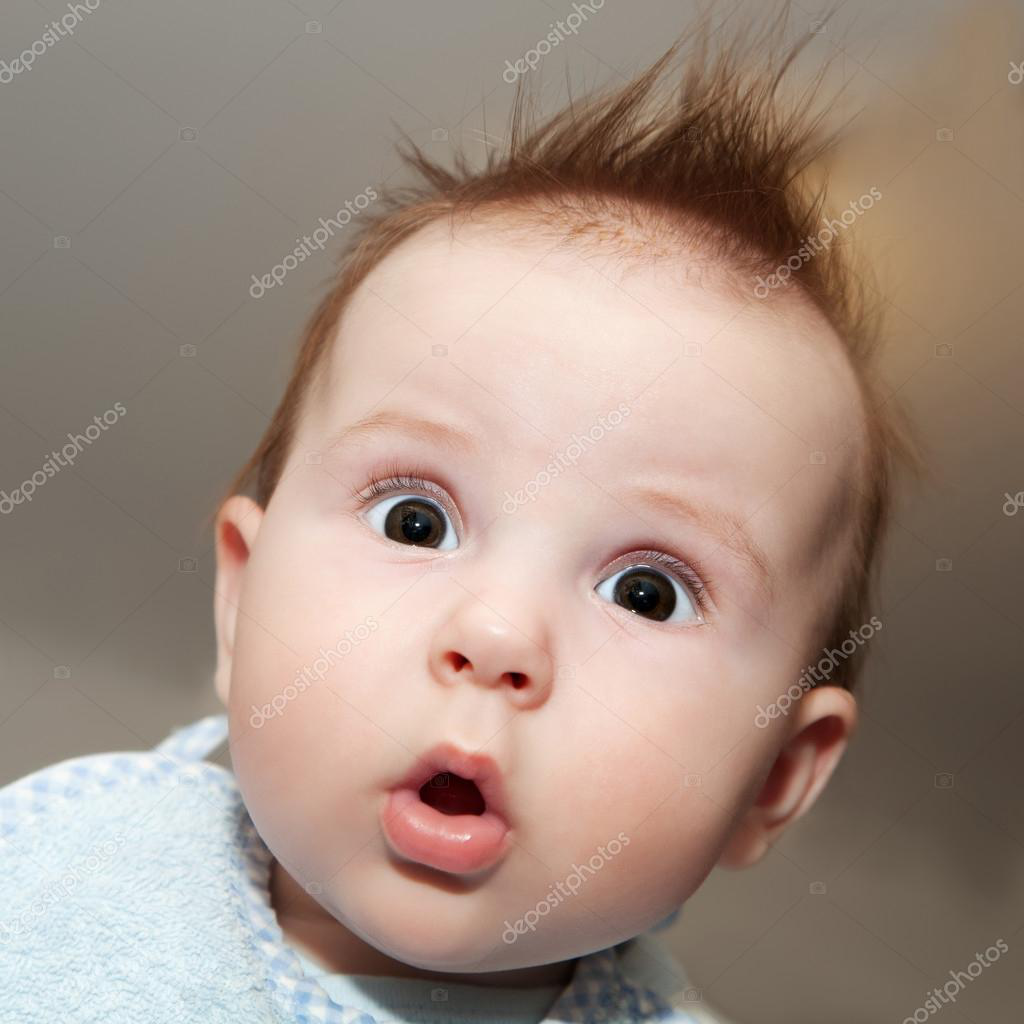

1/1 [==============================] - 0s 42ms/step
La imagen es de la clase: 5


In [234]:
import numpy as np
from PIL import Image

# Cargar la imagen
from PIL import Image

# Cargar la imagen
imagen1 = Image.open('foto12.jpg')

# Mostrar la imagen
imagen1.show()


# Preprocesar la imagen para el modelo
imagen1 = imagen1.resize((48, 48))
imagen1 = imagen1.convert("L")
imagen1_array = np.array(imagen1).reshape((1, 48, 48, 1))
imagen1_array = imagen1_array.astype('float32') / 255

# Hacer la predicción con el modelo
prediction = model.predict(imagen1_array)

# Imprimir la clase con mayor probabilidad
print("La imagen es de la clase:", np.argmax(prediction))


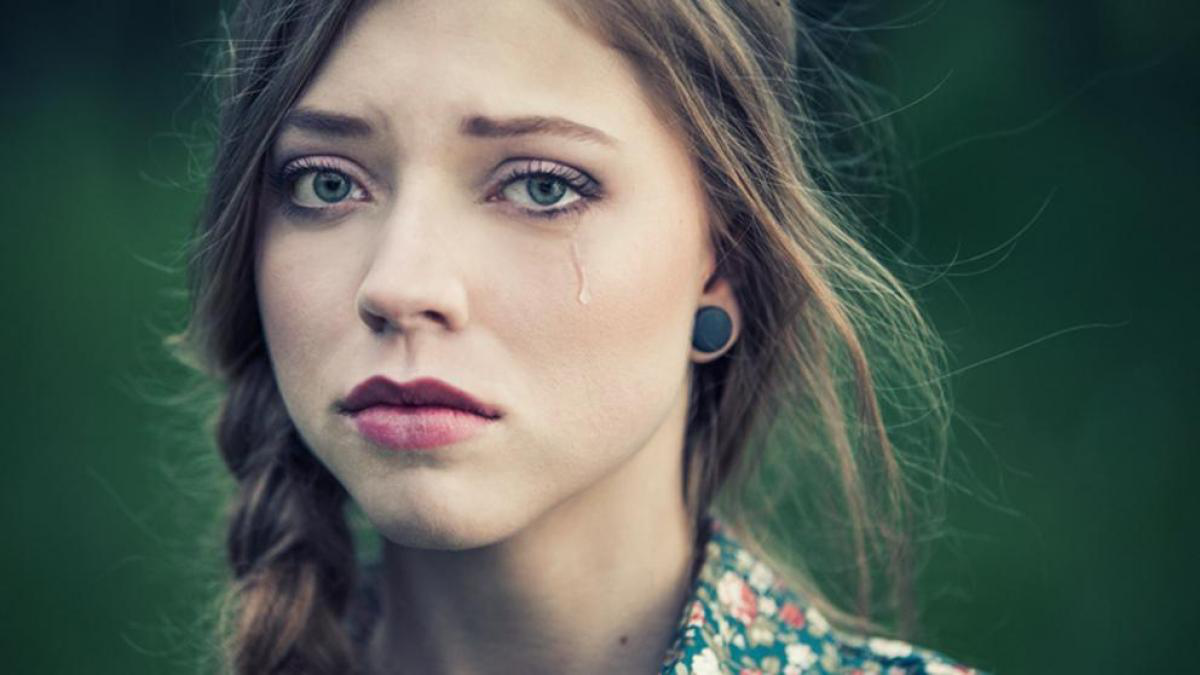

1/1 [==============================] - 0s 40ms/step
La imagen es de la clase: 4


In [217]:
# Cargar la imagen
imagen2 = Image.open('foto2.jpeg')

# Mostrar la imagen
imagen2.show()


# Preprocesar la imagen para el modelo
imagen2 = imagen2.resize((48, 48))
imagen2 = imagen2.convert("L")
imagen2_array = np.array(imagen2).reshape((1, 48, 48, 1))
imagen2_array = imagen2_array.astype('float32') / 255

# Hacer la predicción con el modelo
prediction = model.predict(imagen2_array)

# Imprimir la clase con mayor probabilidad
print("La imagen es de la clase:", np.argmax(prediction))

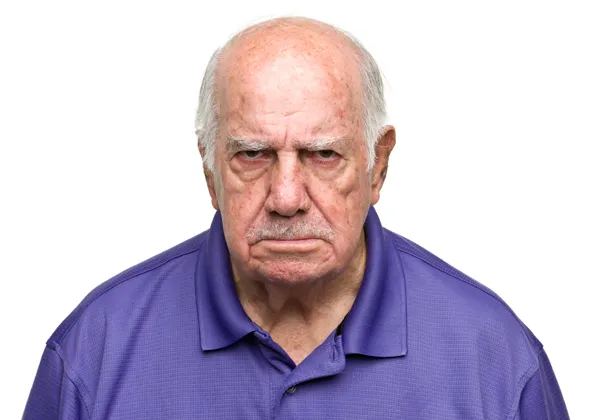

1/1 [==============================] - 0s 25ms/step
La imagen es de la clase: 0


In [218]:
# Cargar la imagen
imagen3 = Image.open('foto5.jpeg')

# Mostrar la imagen
imagen3.show()


# Preprocesar la imagen para el modelo
imagen3 = imagen3.resize((48, 48))
imagen3 = imagen3.convert("L")
imagen3_array = np.array(imagen3).reshape((1, 48, 48, 1))
imagen3_array = imagen3_array.astype('float32') / 255

# Hacer la predicción con el modelo
prediction = model.predict(imagen3_array)

# Imprimir la clase con mayor probabilidad
print("La imagen es de la clase:", np.argmax(prediction))